In [1]:
import pandas as pd
import numpy as np
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

### Load CSV

In [2]:
# data loading & normalization


CSV_PATH = "raw_data/airsim_trajectory.csv"
DF = pd.read_csv(CSV_PATH)

pos_cols = ["POS_X", "POS_Y", "POS_Z"]
vel_cols = ["VEL_X", "VEL_Y", "VEL_Z"]
keep = pos_cols + vel_cols

df = DF[keep].dropna().reset_index(drop=True)

# compute means/stds
pos_mean, pos_std = df[pos_cols].mean().to_numpy(), df[pos_cols].std().to_numpy()
vel_mean, vel_std = df[vel_cols].mean().to_numpy(), df[vel_cols].std().to_numpy()

# normalize
df[pos_cols] = (df[pos_cols] - pos_mean) / pos_std
df[vel_cols] = (df[vel_cols] - vel_mean) / vel_std
# right after loading & normalizing:
print("Check normalized data ranges:")
print(df[pos_cols].describe().loc[['min','max']])
print(df[vel_cols].describe().loc[['min','max']])


norm_params = dict(pos_mean=pos_mean, pos_std=pos_std, vel_mean=vel_mean, vel_std=vel_std)

print(f"Data shape: {df.shape}")
print(df.head())


Check normalized data ranges:
        POS_X     POS_Y     POS_Z
min -0.746205 -3.076668 -2.947978
max  2.476621  3.165231  3.240051
        VEL_X     VEL_Y     VEL_Z
min -4.384539 -7.333667 -8.394185
max  2.925155  7.312655  8.034394
Data shape: (54000, 6)
      POS_X     POS_Y     POS_Z     VEL_X     VEL_Y     VEL_Z
0 -0.706379  0.000168  0.446241 -0.706325  0.004531  0.058994
1 -0.706379  0.000168  0.445696 -0.706325  0.004531  0.050795
2 -0.706379  0.000168  0.445063 -0.706325  0.004531  0.045458
3 -0.706379  0.000168  0.444338 -0.706325  0.004531  0.042052
4 -0.706379  0.000168  0.443594 -0.706325  0.004531  0.040324


### Sliding‑window dataset


In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split

# 10 Hz → 1 s history & 1 s future
sample_interval = 0.1
PAST_STEPS   = int(5.0 / sample_interval)  # = 10
FUTURE_STEPS = int(1.5 / sample_interval)  # = 10

class TrajDataset(Dataset):
    def __init__(self, df, feature_cols):
        """
        df           : pandas DataFrame containing normalized features
        feature_cols : list of 6 column names in order:
                       ["POS_X","POS_Y","POS_Z","VEL_X","VEL_Y","VEL_Z"]
        """
        # grab the whole normalized matrix once
        self.full = df[feature_cols].values.astype(np.float32)  # shape (N,6)
        self.N    = len(self.full) - (PAST_STEPS + FUTURE_STEPS)
        if self.N <= 0:
            raise ValueError(
                f"Not enough data (need ≥{PAST_STEPS+FUTURE_STEPS+1} rows)"
            )

    def __len__(self):
        return self.N

    def __getitem__(self, idx):
        past_window = self.full[idx : idx + PAST_STEPS].copy()                   
        fut_window  = self.full[
            idx + PAST_STEPS : idx + PAST_STEPS + FUTURE_STEPS, :3
        ].copy()                                                                

        origin_pos = past_window[0, :3].copy()[None]  
        past_window[:, :3] -= origin_pos
        fut_window [:, :3] -= origin_pos

        noise_scale = np.clip(past_window.std(axis=0) * 0.1, 0.01, 0.1)
        past_window += np.random.normal(scale=noise_scale, size=past_window.shape).astype(np.float32)

        return torch.from_numpy(past_window), torch.from_numpy(fut_window)

feature_cols = ["POS_X","POS_Y","POS_Z","VEL_X","VEL_Y","VEL_Z"]
required     = PAST_STEPS + FUTURE_STEPS
test_size    = max(required + 1, int(0.2 * len(df)))
train_val_df = df[:-test_size].reset_index(drop=True)
test_df      = df[-test_size:].reset_index(drop=True)

val_len   = int(0.15 * len(train_val_df))
train_len = len(train_val_df) - val_len
train_idx, val_idx = random_split(
    train_val_df, [train_len, val_len], generator=torch.Generator().manual_seed(42)
)
train_df = train_val_df.iloc[train_idx.indices].reset_index(drop=True)
val_df   = train_val_df.iloc[val_idx.indices].reset_index(drop=True)

train_ds = TrajDataset(train_df, feature_cols)
val_ds   = TrajDataset(val_df,   feature_cols)
test_ds  = TrajDataset(test_df,  feature_cols)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl   = DataLoader(val_ds,   batch_size=32, shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size=32, shuffle=False)

print("▶️ Dataset ranges are now stable each epoch")


▶️ Dataset ranges are now stable each epoch


### Transformer model

In [4]:
import torch
import torch.nn as nn

class Seq2SeqTransformer(nn.Module):
    def __init__(self, 
                 input_dim=6, 
                 d_model=128, 
                 nhead=4, 
                 num_encoder_layers=3, 
                 num_decoder_layers=3,
                 dim_feedforward=512, 
                 dropout=0.1):
        super().__init__()
        self.d_model = d_model

        # positional vectors (for learning order of data)
        self.pos_enc = nn.Parameter(torch.randn(1, PAST_STEPS, d_model) * 0.02)
        self.pos_dec = nn.Parameter(torch.randn(1, FUTURE_STEPS, d_model) * 0.02)

        # input projections to turn 6D data into 128 dimensional vectors
        self.src_proj = nn.Linear(input_dim, d_model)
        self.tgt_proj = nn.Linear(3, d_model)  # decoder input only needs XYZ

        # transformer encoder / decoder stacks
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            dim_feedforward=dim_feedforward, 
            dropout=dropout, 
            batch_first=True
        )
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            dim_feedforward=dim_feedforward, 
            dropout=dropout, 
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_encoder_layers)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_decoder_layers)

        # final projection back to XYZ
        self.output = nn.Linear(d_model, 3)
    

    def forward(self, src, tgt):
        """
        src: (B, PAST_STEPS, 6)   -- 6 features: 3 pos + 3 vel (which is our history windows)
        tgt: (B, FUTURE_STEPS, 3) -- teacher-forced past XYZ during training (batch of ground truth future pos during training)
        returns: (B, FUTURE_STEPS, 3)
        """
        # Encoder
        # project and scale (6d to 128d)
        src_emb = self.src_proj(src) * torch.sqrt(torch.tensor(self.d_model, device=src.device))
        # add positional encoding (learning the order of data)
        src_emb = src_emb + self.pos_enc
        # run through encoder stack
        memory = self.encoder(src_emb)

        # Decoder 
        # project decoder inputs
        tgt_emb = self.tgt_proj(tgt)
        # add decoder positional encoding
        tgt_emb = tgt_emb + self.pos_dec
        # run through decoder, attending over encoder memory
        out = self.decoder(tgt_emb, memory)

        # final linear layer back to 3D coordinates
        return self.output(out)


### Training loop


In [5]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Seq2SeqTransformer().to(device)
opt   = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
sched = ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=3, min_lr=1e-7)
criterion = nn.MSELoss()

max_epochs = 100
patience   = 10
best_val_mse = float('inf')
counter      = 0

for epoch in range(1, max_epochs+1):

    model.train()
    running_mse = 0.0
    for past, fut in tqdm(train_dl, desc=f"Epoch {epoch}/{max_epochs}"):
        past, fut = past.to(device), fut.to(device)
        pred = model(past, fut)
        loss = criterion(pred, fut)
        opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        running_mse += loss.item() * past.size(0)

    train_mse = running_mse / len(train_ds)
    train_rmse = math.sqrt(train_mse)


    model.eval()
    val_mse = 0.0
    with torch.no_grad():
        for past, fut in val_dl:
            past, fut = past.to(device), fut.to(device)
            pred = model(past, fut)
            val_mse += criterion(pred, fut).item() * past.size(0)
    val_mse /= len(val_ds)
    val_rmse = math.sqrt(val_mse)

   
    sched.step(val_mse)

    print(f"Epoch {epoch}: Train RMSE={train_rmse:.4f} | Val RMSE={val_rmse:.4f}")


    if val_mse < best_val_mse:
        best_val_mse = val_mse
        counter = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ Saved new best model.")
    else:
        counter += 1
        if counter >= patience:
            print(f"🛑 Early stopping at epoch {epoch}")
            break


Epoch 1/100: 100%|██████████| 1146/1146 [02:56<00:00,  6.51it/s]


Epoch 1: Train RMSE=0.1706 | Val RMSE=0.0225
✅ Saved new best model.


Epoch 2/100: 100%|██████████| 1146/1146 [2:09:31<00:00,  6.78s/it]     


Epoch 2: Train RMSE=0.0580 | Val RMSE=0.0156
✅ Saved new best model.


Epoch 3/100: 100%|██████████| 1146/1146 [04:06<00:00,  4.65it/s]


Epoch 3: Train RMSE=0.0435 | Val RMSE=0.0268


Epoch 4/100: 100%|██████████| 1146/1146 [03:54<00:00,  4.88it/s]


Epoch 4: Train RMSE=0.0354 | Val RMSE=0.0187


Epoch 5/100: 100%|██████████| 1146/1146 [02:34<00:00,  7.43it/s]


Epoch 5: Train RMSE=0.0304 | Val RMSE=0.0094
✅ Saved new best model.


Epoch 6/100: 100%|██████████| 1146/1146 [03:41<00:00,  5.18it/s]


Epoch 6: Train RMSE=0.0266 | Val RMSE=0.0120


Epoch 7/100: 100%|██████████| 1146/1146 [04:33<00:00,  4.19it/s]


Epoch 7: Train RMSE=0.0243 | Val RMSE=0.0142


Epoch 8/100: 100%|██████████| 1146/1146 [04:46<00:00,  4.00it/s]


Epoch 8: Train RMSE=0.0216 | Val RMSE=0.0113


Epoch 9/100: 100%|██████████| 1146/1146 [05:01<00:00,  3.81it/s]


Epoch 9: Train RMSE=0.0199 | Val RMSE=0.0129


Epoch 10/100: 100%|██████████| 1146/1146 [04:53<00:00,  3.91it/s]


Epoch 10: Train RMSE=0.0166 | Val RMSE=0.0104


Epoch 11/100: 100%|██████████| 1146/1146 [03:02<00:00,  6.29it/s]


Epoch 11: Train RMSE=0.0160 | Val RMSE=0.0060
✅ Saved new best model.


Epoch 12/100: 100%|██████████| 1146/1146 [02:40<00:00,  7.14it/s]


Epoch 12: Train RMSE=0.0151 | Val RMSE=0.0086


Epoch 13/100: 100%|██████████| 1146/1146 [03:16<00:00,  5.84it/s]


Epoch 13: Train RMSE=0.0143 | Val RMSE=0.0064


Epoch 14/100: 100%|██████████| 1146/1146 [04:50<00:00,  3.95it/s]


Epoch 14: Train RMSE=0.0136 | Val RMSE=0.0089


Epoch 15/100: 100%|██████████| 1146/1146 [05:08<00:00,  3.71it/s]


Epoch 15: Train RMSE=0.0130 | Val RMSE=0.0058
✅ Saved new best model.


Epoch 16/100: 100%|██████████| 1146/1146 [04:59<00:00,  3.83it/s]


Epoch 16: Train RMSE=0.0123 | Val RMSE=0.0056
✅ Saved new best model.


Epoch 17/100: 100%|██████████| 1146/1146 [04:53<00:00,  3.91it/s]


Epoch 17: Train RMSE=0.0118 | Val RMSE=0.0058


Epoch 18/100: 100%|██████████| 1146/1146 [03:21<00:00,  5.68it/s]


Epoch 18: Train RMSE=0.0113 | Val RMSE=0.0079


Epoch 19/100: 100%|██████████| 1146/1146 [02:41<00:00,  7.09it/s]


Epoch 19: Train RMSE=0.0109 | Val RMSE=0.0052
✅ Saved new best model.


Epoch 20/100: 100%|██████████| 1146/1146 [02:43<00:00,  7.03it/s]


Epoch 20: Train RMSE=0.0103 | Val RMSE=0.0042
✅ Saved new best model.


Epoch 21/100: 100%|██████████| 1146/1146 [02:41<00:00,  7.12it/s]


Epoch 21: Train RMSE=0.0099 | Val RMSE=0.0042


Epoch 22/100: 100%|██████████| 1146/1146 [02:41<00:00,  7.09it/s]


Epoch 22: Train RMSE=0.0096 | Val RMSE=0.0042
✅ Saved new best model.


Epoch 23/100: 100%|██████████| 1146/1146 [02:43<00:00,  7.00it/s]


Epoch 23: Train RMSE=0.0091 | Val RMSE=0.0030
✅ Saved new best model.


Epoch 24/100: 100%|██████████| 1146/1146 [02:40<00:00,  7.13it/s]


Epoch 24: Train RMSE=0.0088 | Val RMSE=0.0045


Epoch 25/100: 100%|██████████| 1146/1146 [02:41<00:00,  7.10it/s]


Epoch 25: Train RMSE=0.0085 | Val RMSE=0.0038


Epoch 26/100: 100%|██████████| 1146/1146 [02:41<00:00,  7.08it/s]


Epoch 26: Train RMSE=0.0082 | Val RMSE=0.0046


Epoch 27/100: 100%|██████████| 1146/1146 [02:43<00:00,  7.02it/s]


Epoch 27: Train RMSE=0.0080 | Val RMSE=0.0034


Epoch 28/100: 100%|██████████| 1146/1146 [02:43<00:00,  7.03it/s]


Epoch 28: Train RMSE=0.0069 | Val RMSE=0.0031


Epoch 29/100: 100%|██████████| 1146/1146 [02:44<00:00,  6.98it/s]


Epoch 29: Train RMSE=0.0069 | Val RMSE=0.0039


Epoch 30/100: 100%|██████████| 1146/1146 [02:45<00:00,  6.93it/s]


Epoch 30: Train RMSE=0.0067 | Val RMSE=0.0040


Epoch 31/100: 100%|██████████| 1146/1146 [02:43<00:00,  7.00it/s]


Epoch 31: Train RMSE=0.0065 | Val RMSE=0.0031


Epoch 32/100: 100%|██████████| 1146/1146 [02:44<00:00,  6.97it/s]


Epoch 32: Train RMSE=0.0060 | Val RMSE=0.0023
✅ Saved new best model.


Epoch 33/100: 100%|██████████| 1146/1146 [02:44<00:00,  6.96it/s]


Epoch 33: Train RMSE=0.0060 | Val RMSE=0.0020
✅ Saved new best model.


Epoch 34/100: 100%|██████████| 1146/1146 [02:52<00:00,  6.64it/s]


Epoch 34: Train RMSE=0.0059 | Val RMSE=0.0017
✅ Saved new best model.


Epoch 35/100: 100%|██████████| 1146/1146 [02:48<00:00,  6.80it/s]


Epoch 35: Train RMSE=0.0058 | Val RMSE=0.0026


Epoch 36/100: 100%|██████████| 1146/1146 [02:43<00:00,  6.99it/s]


Epoch 36: Train RMSE=0.0057 | Val RMSE=0.0020


Epoch 37/100: 100%|██████████| 1146/1146 [02:44<00:00,  6.97it/s]


Epoch 37: Train RMSE=0.0056 | Val RMSE=0.0020


Epoch 38/100: 100%|██████████| 1146/1146 [02:44<00:00,  6.96it/s]


Epoch 38: Train RMSE=0.0055 | Val RMSE=0.0019


Epoch 39/100: 100%|██████████| 1146/1146 [02:44<00:00,  6.97it/s]


Epoch 39: Train RMSE=0.0053 | Val RMSE=0.0021


Epoch 40/100: 100%|██████████| 1146/1146 [02:44<00:00,  6.98it/s]


Epoch 40: Train RMSE=0.0053 | Val RMSE=0.0016
✅ Saved new best model.


Epoch 41/100: 100%|██████████| 1146/1146 [02:44<00:00,  6.99it/s]


Epoch 41: Train RMSE=0.0053 | Val RMSE=0.0016
✅ Saved new best model.


Epoch 42/100: 100%|██████████| 1146/1146 [02:44<00:00,  6.96it/s]


Epoch 42: Train RMSE=0.0052 | Val RMSE=0.0022


Epoch 43/100: 100%|██████████| 1146/1146 [02:44<00:00,  6.97it/s]


Epoch 43: Train RMSE=0.0051 | Val RMSE=0.0019


Epoch 44/100: 100%|██████████| 1146/1146 [02:44<00:00,  6.98it/s]


Epoch 44: Train RMSE=0.0051 | Val RMSE=0.0016
✅ Saved new best model.


Epoch 45/100: 100%|██████████| 1146/1146 [02:43<00:00,  6.99it/s]


Epoch 45: Train RMSE=0.0050 | Val RMSE=0.0015
✅ Saved new best model.


Epoch 46/100: 100%|██████████| 1146/1146 [02:45<00:00,  6.92it/s]


Epoch 46: Train RMSE=0.0050 | Val RMSE=0.0017


Epoch 47/100: 100%|██████████| 1146/1146 [02:44<00:00,  6.96it/s]


Epoch 47: Train RMSE=0.0050 | Val RMSE=0.0014
✅ Saved new best model.


Epoch 48/100: 100%|██████████| 1146/1146 [02:44<00:00,  6.95it/s]


Epoch 48: Train RMSE=0.0049 | Val RMSE=0.0017


Epoch 49/100: 100%|██████████| 1146/1146 [02:44<00:00,  6.96it/s]


Epoch 49: Train RMSE=0.0049 | Val RMSE=0.0020


Epoch 50/100: 100%|██████████| 1146/1146 [02:44<00:00,  6.95it/s]


Epoch 50: Train RMSE=0.0048 | Val RMSE=0.0013
✅ Saved new best model.


Epoch 51/100: 100%|██████████| 1146/1146 [02:45<00:00,  6.94it/s]


Epoch 51: Train RMSE=0.0048 | Val RMSE=0.0018


Epoch 52/100: 100%|██████████| 1146/1146 [02:44<00:00,  6.95it/s]


Epoch 52: Train RMSE=0.0048 | Val RMSE=0.0014


Epoch 53/100: 100%|██████████| 1146/1146 [02:45<00:00,  6.93it/s]


Epoch 53: Train RMSE=0.0047 | Val RMSE=0.0017


Epoch 54/100: 100%|██████████| 1146/1146 [02:44<00:00,  6.96it/s]


Epoch 54: Train RMSE=0.0047 | Val RMSE=0.0014


Epoch 55/100: 100%|██████████| 1146/1146 [02:44<00:00,  6.95it/s]


Epoch 55: Train RMSE=0.0046 | Val RMSE=0.0013


Epoch 56/100: 100%|██████████| 1146/1146 [02:46<00:00,  6.89it/s]


Epoch 56: Train RMSE=0.0046 | Val RMSE=0.0013
✅ Saved new best model.


Epoch 57/100: 100%|██████████| 1146/1146 [02:47<00:00,  6.85it/s]


Epoch 57: Train RMSE=0.0045 | Val RMSE=0.0013
✅ Saved new best model.


Epoch 58/100: 100%|██████████| 1146/1146 [02:45<00:00,  6.94it/s]


Epoch 58: Train RMSE=0.0045 | Val RMSE=0.0014


Epoch 59/100: 100%|██████████| 1146/1146 [02:45<00:00,  6.95it/s]


Epoch 59: Train RMSE=0.0045 | Val RMSE=0.0013


Epoch 60/100: 100%|██████████| 1146/1146 [02:45<00:00,  6.93it/s]


Epoch 60: Train RMSE=0.0045 | Val RMSE=0.0015


Epoch 61/100: 100%|██████████| 1146/1146 [02:45<00:00,  6.93it/s]


Epoch 61: Train RMSE=0.0044 | Val RMSE=0.0015


Epoch 62/100: 100%|██████████| 1146/1146 [02:45<00:00,  6.92it/s]


Epoch 62: Train RMSE=0.0044 | Val RMSE=0.0013


Epoch 63/100: 100%|██████████| 1146/1146 [02:46<00:00,  6.87it/s]


Epoch 63: Train RMSE=0.0044 | Val RMSE=0.0011
✅ Saved new best model.


Epoch 64/100: 100%|██████████| 1146/1146 [02:45<00:00,  6.92it/s]


Epoch 64: Train RMSE=0.0044 | Val RMSE=0.0014


Epoch 65/100: 100%|██████████| 1146/1146 [02:45<00:00,  6.92it/s]


Epoch 65: Train RMSE=0.0044 | Val RMSE=0.0012


Epoch 66/100: 100%|██████████| 1146/1146 [02:46<00:00,  6.89it/s]


Epoch 66: Train RMSE=0.0043 | Val RMSE=0.0012


Epoch 67/100: 100%|██████████| 1146/1146 [02:46<00:00,  6.90it/s]


Epoch 67: Train RMSE=0.0044 | Val RMSE=0.0014


Epoch 68/100: 100%|██████████| 1146/1146 [02:45<00:00,  6.92it/s]


Epoch 68: Train RMSE=0.0043 | Val RMSE=0.0012


Epoch 69/100: 100%|██████████| 1146/1146 [02:45<00:00,  6.92it/s]


Epoch 69: Train RMSE=0.0043 | Val RMSE=0.0013


Epoch 70/100: 100%|██████████| 1146/1146 [02:45<00:00,  6.93it/s]


Epoch 70: Train RMSE=0.0043 | Val RMSE=0.0010
✅ Saved new best model.


Epoch 71/100: 100%|██████████| 1146/1146 [02:45<00:00,  6.92it/s]


Epoch 71: Train RMSE=0.0043 | Val RMSE=0.0012


Epoch 72/100: 100%|██████████| 1146/1146 [02:45<00:00,  6.91it/s]


Epoch 72: Train RMSE=0.0043 | Val RMSE=0.0011


Epoch 73/100: 100%|██████████| 1146/1146 [02:45<00:00,  6.91it/s]


Epoch 73: Train RMSE=0.0043 | Val RMSE=0.0011


Epoch 74/100: 100%|██████████| 1146/1146 [02:45<00:00,  6.91it/s]


Epoch 74: Train RMSE=0.0043 | Val RMSE=0.0011


Epoch 75/100: 100%|██████████| 1146/1146 [02:45<00:00,  6.91it/s]


Epoch 75: Train RMSE=0.0043 | Val RMSE=0.0011


Epoch 76/100: 100%|██████████| 1146/1146 [02:45<00:00,  6.91it/s]


Epoch 76: Train RMSE=0.0042 | Val RMSE=0.0013


Epoch 77/100: 100%|██████████| 1146/1146 [02:45<00:00,  6.91it/s]


Epoch 77: Train RMSE=0.0042 | Val RMSE=0.0012


Epoch 78/100: 100%|██████████| 1146/1146 [02:45<00:00,  6.92it/s]


Epoch 78: Train RMSE=0.0042 | Val RMSE=0.0011


Epoch 79/100: 100%|██████████| 1146/1146 [02:45<00:00,  6.94it/s]


Epoch 79: Train RMSE=0.0042 | Val RMSE=0.0012


Epoch 80/100: 100%|██████████| 1146/1146 [02:45<00:00,  6.94it/s]


Epoch 80: Train RMSE=0.0042 | Val RMSE=0.0012
🛑 Early stopping at epoch 80


### Evaluation & RMSE

 0.1s → 3D RMSE = 0.928 m
 0.2s → 3D RMSE = 0.960 m
 0.3s → 3D RMSE = 0.955 m
 0.4s → 3D RMSE = 0.987 m
 0.5s → 3D RMSE = 0.995 m
 0.6s → 3D RMSE = 0.953 m
 0.7s → 3D RMSE = 0.974 m
 0.8s → 3D RMSE = 0.952 m
 0.9s → 3D RMSE = 0.954 m
 1.0s → 3D RMSE = 0.954 m
 1.1s → 3D RMSE = 0.978 m
 1.2s → 3D RMSE = 0.957 m
 1.3s → 3D RMSE = 0.939 m
 1.4s → 3D RMSE = 1.003 m
 1.5s → 3D RMSE = 0.970 m

=== Trajectory Predictor Profiling ===
Total windows: 10735
Wall-time: 4.998s (0.00047s/window)
 CPU-time: 1.984s
   RAM Δ: -3.8 MB


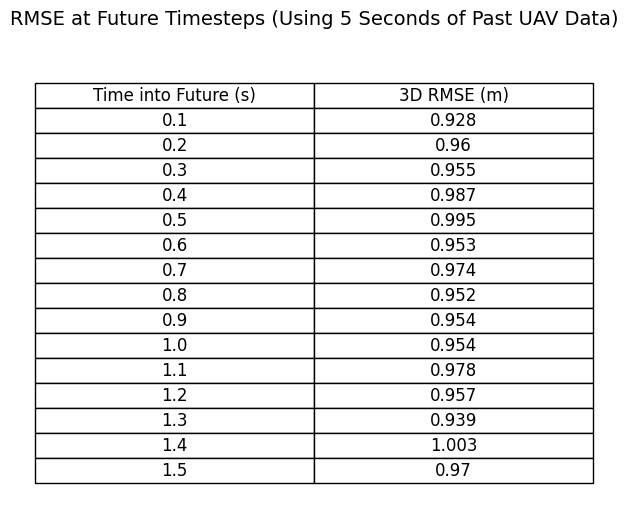

In [ ]:
import torch
import numpy as np
import time
import psutil 

def profile_trajectory_predictor(model, dataloader, device):
    model.eval()

    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()
        gpu0 = torch.cuda.memory_allocated(device)
    else:
        gpu0 = 0

    t0_wall = time.time()
    t0_cpu  = time.process_time()
    process = psutil.Process()
    mem0    = process.memory_info().rss 

    total_windows = 0
    with torch.no_grad():
        for past, fut in dataloader:
            B = past.size(0)
            past, fut = past.to(device), fut.to(device)
            _ = model(past, fut)
            total_windows += B

    t1_wall = time.time()
    t1_cpu  = time.process_time()
    mem1    = process.memory_info().rss
    gpu_peak = torch.cuda.max_memory_allocated(device) if torch.cuda.is_available() else 0

    print("\n=== Trajectory Predictor Profiling ===")
    print(f"Total windows: {total_windows}")
    print(f"Wall-time: {t1_wall - t0_wall:.3f}s "
          f"({(t1_wall - t0_wall) / total_windows:.5f}s/window)")
    print(f" CPU-time: {t1_cpu - t0_cpu:.3f}s")
    print(f"   RAM Δ: {(mem1 - mem0) / (1024 ** 2):.1f} MB")
    if torch.cuda.is_available():
        print(f" GPU Δ peak: {(gpu_peak - gpu0) / (1024 ** 2):.1f} MB")



model = Seq2SeqTransformer().to(device)
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

all_errors = []
with torch.no_grad():
    for past, fut_norm in test_dl:
        past, fut_norm = past.to(device), fut_norm.to(device)
        pred_norm = model(past, fut_norm)

        pos_std  = torch.tensor(norm_params["pos_std"],  device=device).view(1, 1, 3)
        pos_mean = torch.tensor(norm_params["pos_mean"], device=device).view(1, 1, 3)
        pm = pred_norm * pos_std + pos_mean
        fm = fut_norm  * pos_std + pos_mean

        if not all_errors:
            np.save("predicted.npy",    pm[0].cpu().numpy())
            np.save("ground_truth.npy", fm[0].cpu().numpy())

        errs = (pm - fm).cpu().numpy()
        all_errors.append(errs)

all_errors = np.concatenate(all_errors, axis=0)
sq_errs    = np.sum(all_errors ** 2, axis=2)
rmse_by_t  = np.sqrt(np.mean(sq_errs, axis=0))

for i, rmse in enumerate(rmse_by_t, start=1):
    print(f"{0.1 * i:4.1f}s → 3D RMSE = {rmse:.3f} m")

profile_trajectory_predictor(model, test_dl, device)

import pandas as pd
import matplotlib.pyplot as plt

time_steps = [round(0.1 * i, 1) for i in range(1, len(rmse_by_t) + 1)]
rmse_table = pd.DataFrame({
    "Time into Future (s)": time_steps,
    "3D RMSE (m)": [round(x, 3) for x in rmse_by_t]
})

fig, ax = plt.subplots(figsize=(6, 6))
ax.axis('off')
table = ax.table(cellText=rmse_table.values,
                 colLabels=rmse_table.columns,
                 loc='center',
                 cellLoc='center',
                 colLoc='center')

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.5)  

plt.title("RMSE at Future Timesteps (Using 5 Seconds of Past UAV Data)", fontsize=14, pad=20)

plt.savefig("rmse_table.png", dpi=300, bbox_inches='tight')
plt.savefig("rmse_table.pdf", bbox_inches='tight')
plt.show()




### Visualise a prediction

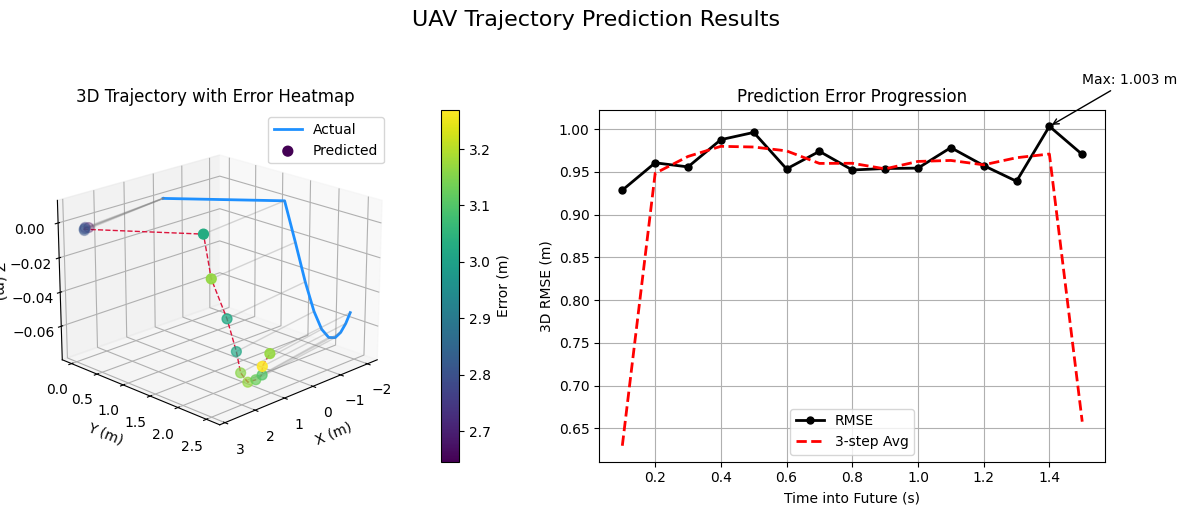

In [44]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

model.eval()
all_errors = []
saved = False

with torch.no_grad():
    for past, fut_norm in test_dl:
        past, fut_norm = past.to(device), fut_norm.to(device)
        pred_norm = model(past, fut_norm)

        pos_std  = torch.tensor(norm_params["pos_std"],  device=device).view(1,1,3)
        pos_mean = torch.tensor(norm_params["pos_mean"], device=device).view(1,1,3)
        pm = pred_norm * pos_std + pos_mean    
        fm = fut_norm  * pos_std + pos_mean    

        if not saved:
            true_fut = fm[0].cpu().numpy()   
            pred_fut = pm[0].cpu().numpy()
            saved = True

        errs = (pm - fm).cpu().numpy()      
        all_errors.append(errs)

all_errors = np.concatenate(all_errors, axis=0)   
sq_errs    = np.sum(all_errors**2, axis=2)        
rmse_by_t  = np.sqrt(np.mean(sq_errs, axis=0))    

true_rel = true_fut - true_fut[0]
pred_rel = pred_fut - true_fut[0]
errors_first = np.linalg.norm(pred_rel - true_rel, axis=1)

T = true_rel.shape[0]
time_steps = np.arange(1, T+1) * 0.1
mov_avg = np.convolve(rmse_by_t, np.ones(3)/3, mode='same')

fig = plt.figure(figsize=(12, 5))
fig.suptitle("UAV Trajectory Prediction Results", y=1.02, fontsize=16)

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot(true_rel[:,0], true_rel[:,1], true_rel[:,2],
         color='dodgerblue', lw=2, label='Actual')
sc = ax1.scatter(pred_rel[:,0], pred_rel[:,1], pred_rel[:,2],
                 c=errors_first, cmap='viridis', s=50, label='Predicted')
ax1.plot(pred_rel[:,0], pred_rel[:,1], pred_rel[:,2],
         color='crimson', linestyle='--', lw=1)
for t, p in zip(true_rel, pred_rel):
    ax1.plot([t[0],p[0]], [t[1],p[1]], [t[2],p[2]],
             color='gray', alpha=0.3, lw=1)
fig.colorbar(sc, ax=ax1, pad=0.1, label='Error (m)')
ax1.set_title("3D Trajectory with Error Heatmap")
ax1.set_xlabel("X (m)"); ax1.set_ylabel("Y (m)"); ax1.set_zlabel("Z (m)")
ax1.legend(); ax1.view_init(elev=20, azim=45)

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(time_steps, rmse_by_t, 'k-o', lw=2, markersize=5, label='RMSE')
ax2.plot(time_steps, mov_avg, 'r--', lw=2, label='3-step Avg')
max_i = np.argmax(rmse_by_t)
ax2.annotate(f"Max: {rmse_by_t[max_i]:.3f} m",
             xy=(time_steps[max_i], rmse_by_t[max_i]),
             xytext=(time_steps[max_i]+0.1, rmse_by_t[max_i]+0.05),
             arrowprops=dict(arrowstyle="->"))
ax2.set_title("Prediction Error Progression")
ax2.set_xlabel("Time into Future (s)")
ax2.set_ylabel("3D RMSE (m)")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


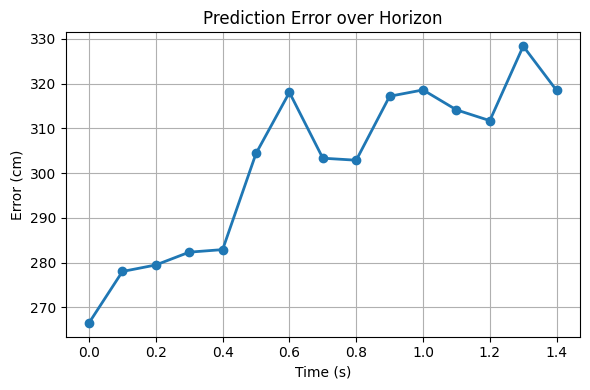

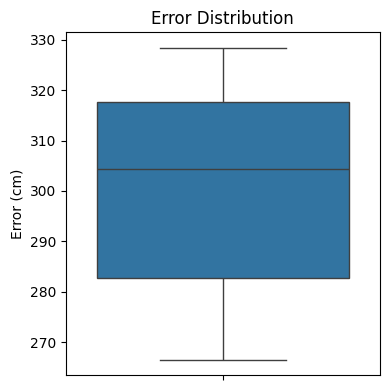

                       Metric
Mean Error (cm)    301.764574
Median Error (cm)  304.404229
Max Error (cm)     328.378746


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


pred = np.load("predicted.npy")    
true = np.load("ground_truth.npy") 
dt   = 0.1                         


errors = np.linalg.norm(pred - true, axis=1)  
t      = np.arange(len(errors)) * dt

plt.figure(figsize=(6,4))
plt.plot(t, errors * 100, 'o-', lw=2)
plt.xlabel("Time (s)")
plt.ylabel("Error (cm)")
plt.title("Prediction Error over Horizon")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(4,4))
sns.boxplot(y=errors * 100)
plt.ylabel("Error (cm)")
plt.title("Error Distribution")
plt.tight_layout()
plt.show()

summary = {
    "Mean Error (cm)"   : errors.mean() * 100,
    "Median Error (cm)" : np.median(errors) * 100,
    "Max Error (cm)"    : errors.max() * 100,
}
print(pd.DataFrame(summary, index=["Metric"]).T)
